# imports

In [2]:
from transformers import AutoProcessor
import requests
import torch
from llava.conversation import conv_templates, SeparatorStyle
from transformers import CLIPImageProcessor
from llava.model import *
from llava.mm_utils import KeywordsStoppingCriteria
from llava.model.multimodal_encoder.builder import build_vision_tower
from io import BytesIO
from PIL import Image
from llava.mm_utils import tokenizer_image_token

# parameters

In [3]:
device = "cuda:0"
model_name = "tabtoyou/KoLLaVA-v1.5-Synatra-7b"

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"
IMAGE_TOKEN_INDEX = -200

# utils

In [4]:
def load_image(image_file):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    return image

# load

In [5]:
tokenizer = AutoProcessor.from_pretrained("tabtoyou/KoLLaVA-v1.5-Synatra-7b")
model = LlavaLlamaForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True, torch_dtype=torch.float16, use_cache=True).to(device)
image_processor = CLIPImageProcessor.from_pretrained(model.config.mm_vision_tower, torch_dtype=torch.float16)

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at tabtoyou/KoLLaVA-v1.5-Synatra-7b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.encoder.layers.18.self_attn.out_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.11.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.16.self_attn.k_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.6.mlp.fc2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.2.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.10.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.17.self_attn.v_proj.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.10.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.10.self_attn.out_proj.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.13.layer_norm1.weight', 'model.vision_tow

# set model & tokenizer

In [6]:
# tokenizer
mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)

2

In [7]:
# vision tower
model.get_model().vision_tower = build_vision_tower(model.config, delay_load=False).to(device) # delayed load가 default로 되어 있어 외부에서 직접 정의
vision_tower = model.get_model().vision_tower
vision_config = vision_tower.config
vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
vision_config.use_im_start_end = mm_use_im_start_end
vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2

# inference

In [10]:
def inference(qs, image_file) :
    image = load_image(image_file)
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv_mode = "mistral"
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0)

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str, "###"]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids.to(device),
            images=image_tensor.unsqueeze(0).half().to(device),
            do_sample=True,
            temperature=0.2,
            max_new_tokens=1024,
            stopping_criteria=[stopping_criteria]).cpu()

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()

    if n_diff_input_output > 0:
        print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
    outputs = tokenizer.batch_decode(output_ids[:, input_token_len:-1], skip_special_tokens=True)[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[:-len(stop_str)]
    outputs = outputs.strip()
    print(outputs)

사진 속 동물은 흰 개입니다.


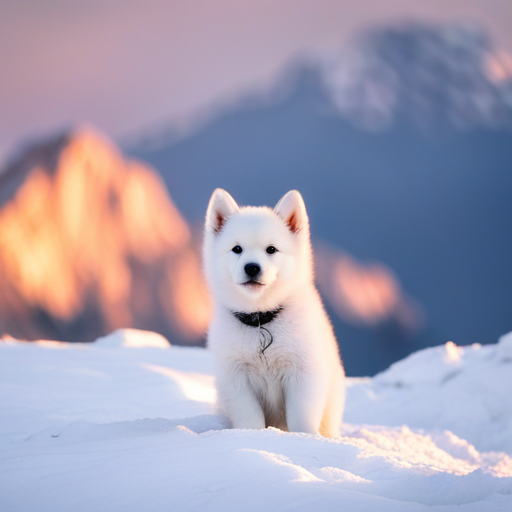

In [12]:
image_file = "images/dog.png"
query = "사진 속 동물은 무엇인가요?"
ex_img = load_image(image_file)
inference(qs=query, image_file=image_file)
ex_img

이미지에는 냉장고에 다양한 음식이 있습니다. 냉장고 안에는 딸기, 당근, 블루베리, 우유, 요구르트, 빵, 치즈, 병 등이 있습니다. 이러한 품목은 냉장고에 다양한 식품이 있음을 나타냅니다.


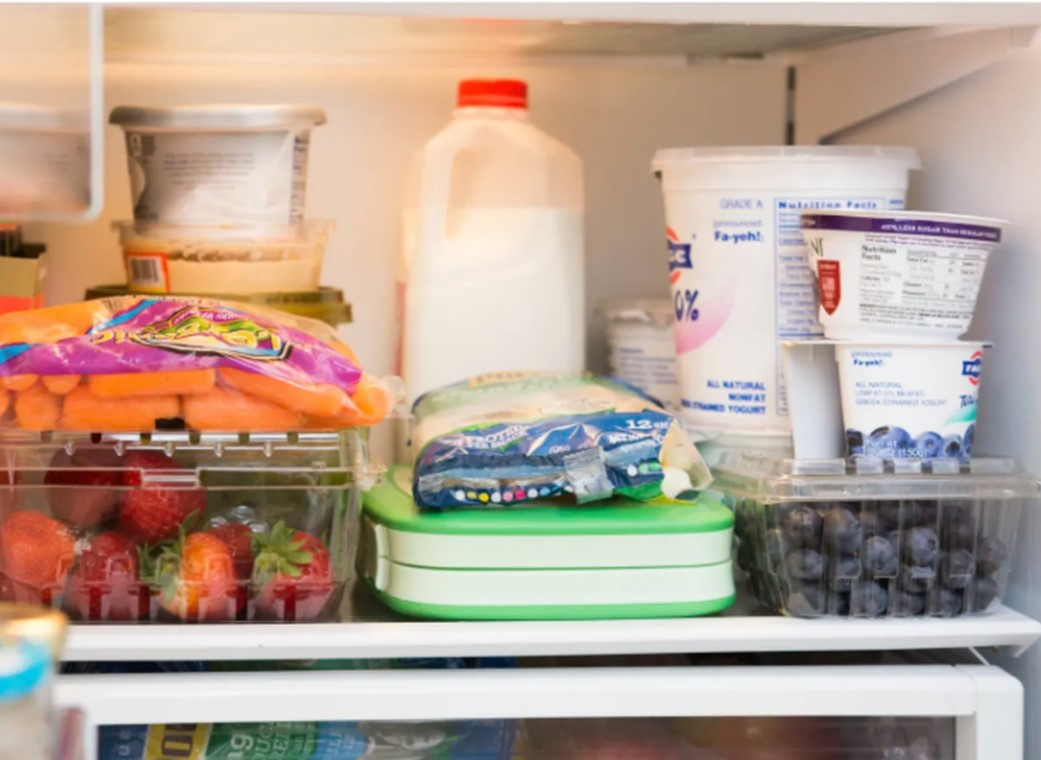

In [13]:
image_file = "images/food.png"
query = "사진 속엔 어떤 음식들이 있나요?"
ex_img = load_image(image_file)
inference(qs=query, image_file=image_file)
ex_img